### Install Dependencies

In [121]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers trl peft accelerate bitsandbytes
!pip install datasets scipy ipywidgets matplotlib

### Load Dataset

In [2]:
import os
print(os.getcwd())

D:\MSAI\Thesis and Project\Mistral\unsloth_mistral-7b-instruct-v0.2-bnb-4bit


In [4]:
from datasets import load_dataset
Data_Path = '../Data/Cleaned_Data/'
training_data   = load_dataset("json", data_files=Data_Path+"Claims_Perspectives-Training.jsonl", split = "train")
validation_data = load_dataset("json", data_files=Data_Path+"Claims_Perspectives-Validation.jsonl", split = "train")

Generating train split: 0 examples [00:00, ? examples/s]

### Load Model and Tokenizer

In [123]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2000 # Choose any! Mistral auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.
model_name = "unsloth/mistral-7b-instruct-v0.2-bnb-4bit"

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name,
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

==((====))==  Unsloth: Fast Mistral patching release 2024.5
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


In [124]:
# Building Lora enabled model
model = FastLanguageModel.get_peft_model(
    model,
    r = 32, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 64,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

### Formatting Prompts

In [125]:
rumour_prompt = """###Instruction:
Retrieve the corresponding perspectives for the given Claim.

###Claim:
{claim}

###Perspectives:
1) {l1} : {p1}

2) {l2} : {p2}"""

In [126]:
EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
BOS_TOKEN = tokenizer.bos_token
def formatting_prompts_func(examples, check=True):
    # print(examples)
    inputs       = examples['claim']
    outputs      = examples['perspectives']
    texts = []
    if len(outputs) > 1:
        text = BOS_TOKEN + rumour_prompt.format(claim=inputs,
                                                l1=outputs[0]['label'],
                                                p1=outputs[0]['text'],
                                                l2=outputs[1]['label'],
                                                p2=outputs[1]['text']) + EOS_TOKEN
        texts.append(text)
    else:
        text = BOS_TOKEN + rumour_prompt.format(claim=inputs,
                                                l1=outputs[0]['label'],
                                                p1=outputs[0]['text'],
                                                l2="",
                                                p2="") + EOS_TOKEN
        texts.append(text)
    return { "text" : texts } if check else texts

### Check for average sequence length (input Id's) in our training data

In [127]:
def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_prompts_func(prompt, False)[0])

In [128]:
tokenized_train_dataset = training_data.map(generate_and_tokenize_prompt)
tokenized_val_dataset   = validation_data.map(generate_and_tokenize_prompt)

In [129]:
print("EOS Token input_id: ", tokenizer(tokenizer.eos_token)['input_ids'])
print("BOS Token input_id: ", tokenizer(tokenizer.bos_token)['input_ids'])
print(tokenized_train_dataset[1]['input_ids'])

EOS Token input_id:  [1, 2]
BOS Token input_id:  [1, 1]
[1, 1, 774, 18066, 28747, 13, 8637, 12891, 272, 7606, 3708, 26859, 354, 272, 2078, 1366, 2371, 28723, 13, 13, 27332, 27154, 28747, 13, 28743, 498, 7437, 12170, 374, 11403, 354, 28705, 3197, 2907, 1124, 274, 6795, 298, 5372, 304, 1366, 2371, 28713, 2499, 1691, 18375, 883, 13, 13, 27332, 13603, 26859, 28747, 13, 28740, 28731, 5861, 714, 264, 277, 498, 7437, 16032, 477, 3042, 15591, 403, 16783, 3694, 354, 680, 821, 28705, 3486, 1159, 1342, 1063, 654, 2358, 298, 6076, 323, 26344, 20733, 516, 3031, 1938, 369, 727, 3140, 461, 1953, 290, 5680, 282, 624, 282, 9278, 400, 2068, 298, 14591, 304, 1424, 5525, 690, 400, 13966, 390, 264, 6100, 304, 5034, 288, 3057, 346, 5248, 13, 13, 1237, 879, 1571, 24727, 294, 403, 19408, 298, 272, 6556, 356, 10060, 4084, 28705, 1024, 264, 3014, 3031, 3517, 562, 403, 11804, 8837, 1944, 3694, 3403, 1024, 516, 13758, 395, 272, 11092, 302, 264, 295, 454, 5295, 5599, 1987, 22144, 293, 28705, 369, 4558, 272, 4242, 

[312, 1402, 788, 602, 85, 654, 384, 396, 1267, 893, 418, 1273, 895, 810, 1003, 1228, 343, 440, 1068, 1013, 500, 527, 736, 1655, 141, 2421, 772, 421, 257, 1235, 284, 1065, 368, 1205, 414, 756, 776, 2191, 443, 511, 176, 715, 2425, 64, 866, 1136, 466, 262, 268, 588, 360, 1127, 109, 1731, 1342, 1656, 1733, 249, 574, 873, 703, 1320, 647, 216, 251, 610, 693, 430, 909, 1018, 486, 1239, 666, 1065, 1652, 284, 944, 347, 86, 398, 298, 1244, 279, 1154, 424, 688, 2220, 490, 705, 1092, 838, 315, 332, 624, 844, 1026, 1027, 668, 565, 1012, 2027, 222, 311, 450, 869, 663, 603, 551, 992, 250, 303, 79, 523, 549, 221, 220, 427, 67, 1112, 258, 884, 668, 572, 615, 1235, 1107, 1321, 506, 1342, 1043, 769, 997, 603, 411, 804, 661, 593, 744, 627, 590, 833, 2422, 1243, 1965, 941, 584, 604, 772, 2064, 416, 401, 932, 445, 969, 451, 1992, 816, 1365, 249, 676, 870, 1046, 114, 1765, 2119, 669, 1194, 539, 514, 331, 756, 320, 181, 656, 1077, 529, 599, 547, 643, 616, 798, 84, 571, 889, 489, 624, 235, 555, 127, 1147, 385,

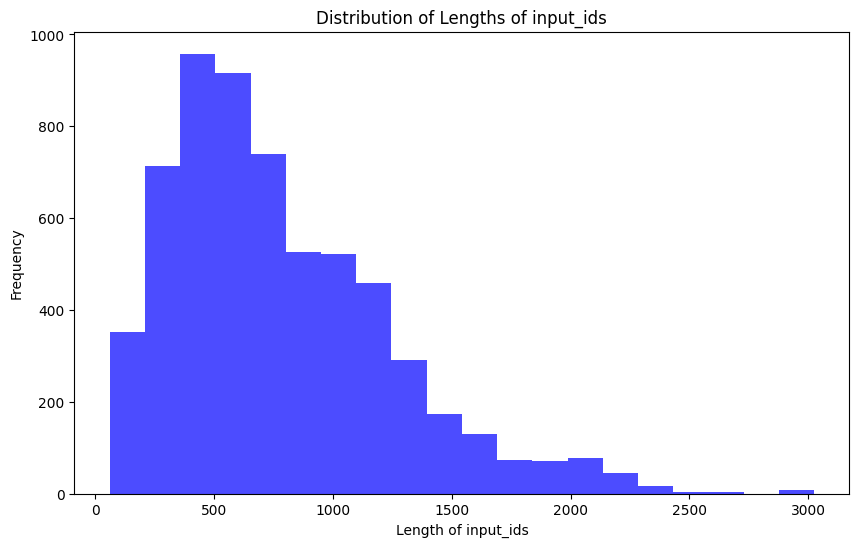

In [130]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(lengths)

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [131]:
Final_tokenized_training   = training_data.map(formatting_prompts_func)
Final_tokenized_validation = validation_data.map(formatting_prompts_func)

### Check memory stats and print trainable parameters

In [132]:
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.748 GB.
12.844 GB of memory reserved.


In [133]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [134]:
print_trainable_parameters(model)

trainable params: 83886080 || all params: 3835957248 || trainable%: 2.186835633888691


### Modify data for SFTTrainer adaptation

In [135]:
def Trainer_adaptation(prompt):
    prompt['text'] = prompt['text'][0]
    return prompt

In [136]:
Final_tokenized_training   = Final_tokenized_training.map(Trainer_adaptation)
Final_tokenized_validation = Final_tokenized_validation.map(Trainer_adaptation)

### Training using SFTTrainer

In [137]:
# Tokenizer settings
tokenizer.pad_token=tokenizer.eos_token
tokenizer.padding_side='left'

In [138]:
project = "Mistral-finetune"
base_model_name = model_name
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

In [139]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = Final_tokenized_training,
    eval_dataset=Final_tokenized_validation,
    dataset_text_field = "text",
    max_seq_length = max_seq_length, # As calculated from above bar plot padding and truncation at 2000 tokens (Custom to train + val data)
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        gradient_checkpointing=True,
        warmup_steps = 5,
        num_train_epochs = 1,
        #max_steps = None, # Set num_train_epochs = 1 for full training runs
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 20,
        logging_dir="./logs",
        save_strategy="steps", # Save the model checkpoint every logging step
        save_steps=20,         # Save checkpoints every 50 steps
        evaluation_strategy="steps",
        eval_steps=20,         # Evaluate and save checkpoints every 50 steps
        do_eval=True,          # Perform evaluation at the end of training
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
    ),
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=2):   0%|          | 0/4859 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/1215 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:318: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 4,859 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 607
 "-____-"     Number of trainable parameters = 83,886,080


Step,Training Loss,Validation Loss
25,1.815100,1.553065
